In [3]:
#@Author Corentin

In [4]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

# Creation de deux classe: Fitness et City

La classe city va créer une ville avec des coordonnées, une méthode (avec comme paramètre elle même et une ville) afin de calculer sa distance avec une ville et une autre méthode afin de renvoyer une coordonnée nettoyé. 

In [5]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

La classe fitness va contenir 3 méthodes : 
- La première initialise une route avec une distance et un fitness égale à 0
- La deuxieme calcule les distances des routes voisines en prenant en compte que nous devons revenir à note sommet de départ.
- La troisième calcul le fitness du chemin qui est empruntée. Elle prend l'inverse de la distance calculée ci-dessus, en effet, plus une distance est petite, plus son fitness est élevé. 


In [6]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

# Création de la population :

Nous allons créer notre population. Pour cela, nous allons créer une fonction qui produit des itinéraires qui répondent aux conditions. Pour créer un individu, nous selectionnons au hasard l'ordre dans lequel nous visitons chaque ville :   

In [7]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

La fonction ci-dessus nous produit un individu, mais dans notre cas, nous voulons une population complète, donc nous implémenterons une liste vide qui contiendra une population initiale, mais aussi une boucle qui de 0 à une taille de population voulu, va créer un individu et le mettra dans la liste qu'il retournera à la fin. 

In [8]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

# Determination du fitness 

Le fitness est le score qui va définir si oui ou non cette route est plus viable que les autres. Nous allons don créer une fonction qui "simulera la survie des individus les plus aptes", et donc qui classera chaque individu de la population ci-dessus. La sortie de cette fonction retournera une liste triée avec les identifiants des itinéraires et chaque score de fitness associé. 

In [9]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

# Séléction du pool de reproduction

Il existe quelques options pour sélectionner les parents qui seront utilisés pour créer la prochaine génération. Les approches les plus courantes sont soit la sélection proportionnelle de la condition physique (alias «sélection de la roulette») ou la sélection de tournoi: 
- La sélection proportionnelle de la forme physique (la version implémentée ci-dessous): La forme physique de chaque individu par rapport à la population est utilisée pour attribuer une probabilité de sélection. 
- Sélection du tournoi: Un certain nombre d'individus sont sélectionnés au hasard dans la population et celui avec la meilleure forme physique du groupe est choisi comme premier parent. Ceci est répété pour choisir le deuxième parent. 

Une autre caractéristique de conception à considérer est l'utilisation de l'élitisme. Avec l'élitisme, les individus les plus performants de la population passeront automatiquement à la génération suivante, garantissant la persistance des individus les plus performants.

Par souci de clarté, nous allons créer le pool de couplage en deux étapes. Tout d'abord, nous utiliserons la sortie de rankRoutes pour déterminer les itinéraires à sélectionner dans notre fonction de sélection. 
Dans les lignes 3 à 5, nous avons configuré la roulette en calculant un poids relatif de fitness pour chaque individu. À la ligne 9, nous comparons un nombre tiré au hasard à ces poids pour sélectionner notre pool d'accouplements. Nous souhaitons également conserver nos meilleures routes. 

Nous introduisons donc l'élitisme à la ligne 7. En fin de compte, la fonction de sélection renvoie une liste d'ID de route, que nous pouvons utiliser pour créer le pool de correspondances dans la fonction matingPool.

In [10]:
def selection(popRanked, eliteSize):
    #Liste vide des resultats 
    selectionResults = []
    #init d'un dataframe contenant notre population (avec un colonne ID et une avec son score Fitness)
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    #ajout d'une colonne avec la valeur du fitness cumulé avec ceux ci-dessus
    df['cum_sum'] = df.Fitness.cumsum()
    #ajout d'une colonne avec le pourcentage de prise de cette individu. 
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    #ajout d'un ou des membre(s) élite(s) dans notre selection
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    #choix de manière aléatoire d'individu (en fonction de son pourcentage)
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Maintenant que nous avons les ID des routes qui constituront notre pool d'accouplement, nous allons pouvoir créer notre pool d'accouplement. Pour cela, nous allons simplement extraire les individus selectionnées dans notre population. 

In [11]:
def matingPool(population, selectionResults):
    #liste des choix 
    matingpool = []
    #Pour tout element des resultats, si l'index est égale à l'index de la selection, on l'ajoute dons notre liste
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

# La reproduction

In [12]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Ensuite, nous généraliserons cela pour créer notre population de descendants. À la ligne 5, nous utilisons l'élitisme pour conserver les meilleurs itinéraires de la population actuelle. Ensuite, à la ligne 8, nous utilisons la fonction d'accouplement pour remplir le reste de la prochaine génération.

In [13]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

# Mutation 

La mutation servira à nous éloigner d'une convergance local en introduisant des nouvelles routes qui nous permetterons d'explorer d'une partie de l'espace des solutions. 

In [14]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
            
    return individual

Ensuite, nous pouvons étendre la fonction de mutation pour parcourir la nouvelle population. 

In [15]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

# Repetition

L'algorithme est presque complet, il faut rassembler les fonctions et méthodes que nous avons créer pour produire des nouvelles génération. Premièrement: 
- Nous classons les itinéraires de la génération actuelle à l'aide de rankRoutes. 
- Nous déterminons ensuite nos parents potentiels en exécutant la fonction de sélection, qui nous permet de créer le pool de couplage à l'aide de la fonction matingPool. 
- Enfin, nous créons ensuite notre nouvelle génération en utilisant la fonction racePopulation puis en appliquant une mutation en utilisant la fonction mutatePopulation.

In [16]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

# Evolution en mouvement

Nous avons tout ce qu'il faut pour mettre en place l'algorithme. Tout ce que nous devons faire est de créer la population initiale, puis nous pouvons parcourir autant de générations que nous le souhaitons. Bien sûr, nous voulons également voir le meilleur itinéraire et les améliorations que nous avons apportées, nous capturons donc la distance initiale sur la ligne 3 , la distance finale sur la ligne 8 et le meilleur itinéraire en ligne 9.

In [17]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

# Exécuter l'algorithme 

L'execution de l'algorithme se fera en deux étapes : Premièrement, nous avons besoin d'une liste de villes entre lesquelles voyager. Pour cette démonstration, nous allons créer une liste de 25 villes aléatoires (un nombre apparemment petit de villes, mais la bruteforce normalement devrait tester plus de 300 sextillions de routes!):


In [24]:
cityList = []

for i in range(0,1000):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Ensuite, l'exécution de l'algorithme génétique est une simple ligne de code. Dans cet exemple, nous avons 100 individus dans chaque génération, gardons 20 individus d'élite, utilisons un taux de mutation de 1% pour un gène donné et parcourons 500 générations:

In [27]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 102123.74703616778


KeyboardInterrupt: 

# Bonus : Afficher graphiquement l'amélioration

In [21]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

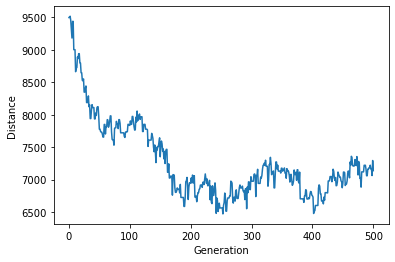

In [22]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)